In [13]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

else:
    %cd /home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
import haiku as hk
import numpy as np
import optax
from nn_util import *
from optim_util import *
from bnn_models import *
from train_utils import *
from data_utils import *
from hpo_util import *
from exp_utils import *
from exp_utils import *
plt.style.use('ggplot')
%load_ext autoreload

/home/abdu/bio_ai/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
if SERVER:
    data_dir = "/home/abdu/bio_ai/moses-incons-pen-xp/data"
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

### GDSC Cell Line

In [4]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_data = pd.read_csv(f"{gdsc_dir}/gdsc_gene_expr.csv", index_col="model_id")
gdsc_exp_data.shape

(442, 37263)

In [5]:
cols = gdsc_exp_data.columns.to_list()
cancer_driver_genes_df = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")
driver_syms = cancer_driver_genes_df["symbol"].to_list()
driver_sym_list = [sym.strip() for sym in cols if sym in driver_syms]

In [6]:
gdsc_response_data = pd.read_csv(f"{gdsc_dir}/GDSC2_fitted_dose_response_24Jul22.csv", index_col="SANGER_MODEL_ID")
gdsc_response_data

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,
SIDM01132,GDSC2,401,18945558,683667,PFSK-1,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-1.462148,0.930105,0.088999,0.432482
SIDM00848,GDSC2,401,18945796,684052,A673,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-4.869447,0.614932,0.111423,-1.420322
SIDM00263,GDSC2,401,18946078,684057,ES5,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-3.360684,0.790953,0.142754,-0.599894
SIDM00269,GDSC2,401,18946335,684059,ES7,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-5.045014,0.592624,0.135642,-1.515791
SIDM00203,GDSC2,401,18946617,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.000100,0.1,-3.741620,0.733992,0.128066,-0.807038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00216,GDSC2,401,19187490,1659928,SNU-175,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.134495,0.976798,0.074441,0.159946
SIDM00214,GDSC2,401,19187943,1660034,SNU-407,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,8.575555,0.913182,0.057743,-1.626059
SIDM00194,GDSC2,401,19188201,1660035,SNU-61,COREAD,2499,N-acetyl cysteine,Metabolism,Metabolism,1101,Y,2.001054,2000.0,10.520666,0.974889,0.058094,0.602364


(array([ 15.,   1.,   1., 103., 124.,  33.,   0.,   0.,   1.,   8.]),
 array([ 225. ,  372.3,  519.6,  666.9,  814.2,  961.5, 1108.8, 1256.1,
        1403.4, 1550.7, 1698. ]),
 <BarContainer object of 10 artists>)

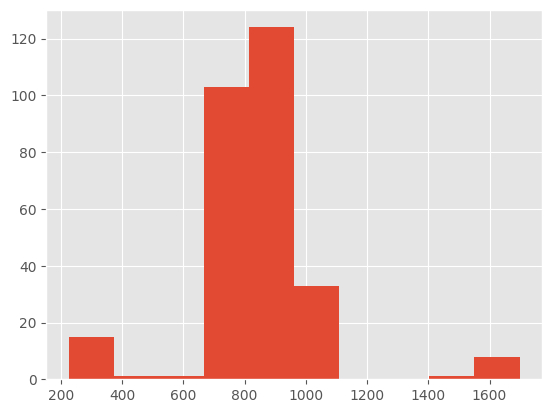

In [77]:
plt.hist(gdsc_response_data["DRUG_NAME"].value_counts())

In [ ]:
gdsc_response_data["DRUG_NAME"].value_counts()

In [12]:
gdsc_response_data[gdsc_response_data["DRUG_NAME"] == "Oxaliplatin"]

,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
SANGER_MODEL_ID,,,,,,,,,,,,,,,,,,
SIDM01132,GDSC2,401,18945597,683667,PFSK-1,MB,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.010005,10.0,3.229677,0.934151,0.102048,-0.333572
SIDM00848,GDSC2,401,18945854,684052,A673,UNCLASSIFIED,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.010005,10.0,3.634207,0.953987,0.111412,-0.100520
SIDM00263,GDSC2,401,18946136,684057,ES5,UNCLASSIFIED,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.010005,10.0,2.716484,0.910922,0.093463,-0.629225
SIDM00269,GDSC2,401,18946393,684059,ES7,UNCLASSIFIED,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.010005,10.0,2.393428,0.891174,0.110528,-0.815339
SIDM00203,GDSC2,401,18946675,684062,EW-11,UNCLASSIFIED,1089,Oxaliplatin,DNA alkylating agent,DNA replication,1046,Y,0.010005,10.0,3.646806,0.935195,0.070647,-0.093262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00214,GDSC2,401,19187834,1660034,SNU-407,COREAD,1806,Oxaliplatin,DNA alkylating agent,DNA replication,1043,Y,0.020011,20.0,4.914151,0.949983,0.058997,-0.014742
SIDM00194,GDSC2,401,19188104,1660035,SNU-61,COREAD,1806,Oxaliplatin,DNA alkylating agent,DNA replication,1043,Y,0.020011,20.0,5.445251,0.965901,0.032154,0.309839
SIDM00193,GDSC2,401,19188372,1660036,SNU-81,COREAD,1806,Oxaliplatin,DNA alkylating agent,DNA replication,1043,Y,0.020011,20.0,4.221093,0.957405,0.044450,-0.438304


In [8]:
from scipy.sparse import csgraph
J = np.load(f"{data_dir}/cell_line/cancer_genes_net.npy")
L = csgraph.laplacian(J, normed=True)
J_zero = np.zeros_like(J)

In [15]:
%autoreload
import warnings
warnings.filterwarnings("ignore")

hp_configs = {"epochs": 500, "act_fn": "swish",
              "beta": 0.25, "hidden_sizes": [500],
              "num_models": 2}

exp_dir = f"{data_dir}/exp_data_5/cancer/gdsc"
drug_ids = [1502, 1814, 1007, 1558, 1031, 1037, 1039] # Bicalutamide, Nelarabine, Docetaxel, Lapatinib, elesclomol, bx795, sl0101
VERSION = "1b"

seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
print(len(curr_seeds))
# run_multiple_drugs(curr_seeds, gdsc_exp_data, gdsc_response_data,
#                    driver_sym_list, drug_ids, L, VERSION, exp_dir, hp_configs, 900)

20


In [78]:
%autoreload
res_dfs = {"bicalutamide": None, "nelarabine": None, "docetaxel": None,
           "lapatinib": None, "elesclomol": None, "bx795": None, "sl0101": None,
           "tamoxifen": None, "bortezomib": None}

version = "1c"

for key in res_dfs:
    save_dir = f"{exp_dir}/{key}"
    res_dfs[key] = get_result_df(seeds, save_dir, version)

In [97]:
res_dfs["nelarabine"].groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.407953,0.276084
BNN w/o BG,0.406361,0.277610
RF,0.399573,0.310289


In [98]:
res_dfs["nelarabine"]

,seed,model,test_rmse,test_r2_score
0,422,RF,0.342807,0.297342
1,422,BNN w/o BG,0.440996,-0.162828
2,422,BNN + BG,0.355954,0.242409
3,261,RF,0.462867,0.352122
4,261,BNN w/o BG,0.476982,0.312007
5,261,BNN + BG,0.478819,0.306695
6,968,RF,0.342191,0.337135
7,968,BNN w/o BG,0.316558,0.432725
8,968,BNN + BG,0.322544,0.411069
9,282,RF,0.404493,0.332258


In [64]:
def get_per_model_res(res_df):
    bg_bnn_rmse = res_df[res_df["model"] == "BNN + BG"]["test_rmse"].to_list()
    bnn_rmse = res_df[res_df["model"] == "BNN w/o BG"]["test_rmse"].to_list()
    rf_rmse  = res_df[res_df["model"] == "RF"]["test_rmse"].to_list()

    return [bg_bnn_rmse, bnn_rmse, rf_rmse]

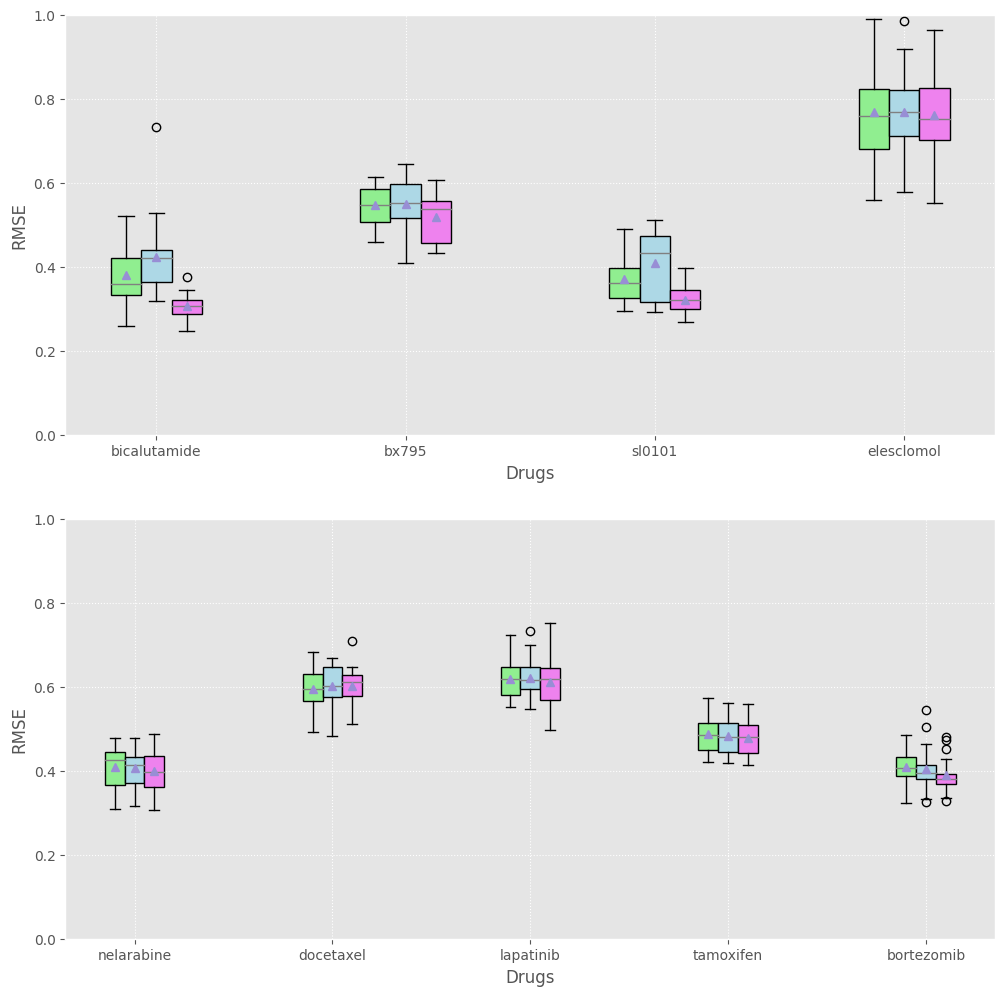

In [81]:
g1 = get_per_model_res(res_dfs["bicalutamide"])
g2 = get_per_model_res(res_dfs["bx795"])
g3 = get_per_model_res(res_dfs["sl0101"])
g4 = get_per_model_res(res_dfs["elesclomol"])
g5 = get_per_model_res(res_dfs["nelarabine"])
g6 = get_per_model_res(res_dfs["docetaxel"])
g7 = get_per_model_res(res_dfs["lapatinib"])
g8 = get_per_model_res(res_dfs["tamoxifen"])
g9 = get_per_model_res(res_dfs["bortezomib"])

res_group1 = [g1, g2, g3, g4]
res_group2 = [g5, g6, g7, g8, g9]
super_group = [res_group1, res_group2]
colors = ["lightgreen", "lightblue", "violet"]

labels = [["bicalutamide", "bx795", "sl0101", "elesclomol"],
          ["nelarabine", "docetaxel", "lapatinib", "tamoxifen", "bortezomib"]]

fig, axs = plt.subplots(2, 1, figsize=(12, 12))
for k, res_gp in enumerate(super_group):
    ax = axs[k]
    lbls = labels[k]
    width = 1/len(lbls)
    symbol = 'r+'
    # ymin = min ([val  for dg in res_gp  for data in dg for val in data]) - 0.05
    # ymax = max ([val  for dg in res_gp  for data in dg for val in data]) + 0.05
    # ax.set_ylim(ymin, ymax)
    ax.set_ylim(0., 1.)
    ax.grid(True, linestyle="dotted")
    ax.set_axisbelow(True)
    ax.set_xlabel("Drugs")
    ax.set_ylabel("RMSE")

    space = len(res_gp)/2
    offset = len(res_gp)/2
    middle_pos = []
    for i, dg in enumerate(res_gp):
        _off = (0 - space + (0.8+i))
        xlocations  = [ x*width + _off for x in range(len(dg))]
        pos = [x+_off*(width+0.8) for x in xlocations]
        # print(_off)
        middle_pos.append(pos[1])
        bplot = ax.boxplot(dg,
                           positions=pos,
                           showmeans=True,
                           labels=[""]*len(dg),
                           widths=width,
                           medianprops=dict(color="grey"),
                           patch_artist=True)

        for patch, color in zip(bplot["boxes"], colors):
            patch.set_facecolor(color)

    ax.set_xticks(middle_pos)
    ax.set_xticklabels(lbls, rotation=0)

plt.show()

In [178]:
%autoreload
hp_configs = {"epochs": 500, "num_cycles": 50, "batch_size": 16, "act_fn": "swish",
              "beta": 0.25, "lr_0": 1e-3, "disc_lr_0": 0.5, "hidden_sizes": [500],
              "temp": 1.0, "sigma": 1.0, "num_models": 2}

exp_dir = f"{data_dir}/exp_data_5/cancer/gdsc"

VERSION = "1b"

seeds = [422,261,968,282,739,573,220,413,745,775,482,442,210,423,760,57,769,920,226,196]
curr_seeds = seeds
print(len(curr_seeds))
# run_multiple_drugs(curr_seeds, gdsc_exp_data, gdsc_response_data,
#                    driver_sym_list, [1039], L, VERSION, exp_dir, hp_configs)

20
Starting exp for Drug id: 1039/sl0101
Total samples for drug 1039/sl0101: 117


100%|██████████████████████████████████████████████████████████████████████████████████████| 20/20 [48:55<00:00, 146.79s/it]

Done
Done for drug: 1039/sl0101


In [57]:
tamoxifen_res = res_dfs["bortezomib"]
tamoxifen_res = tamoxifen_res[tamoxifen_res["seed"] != 220]
tamoxifen_res = tamoxifen_res[tamoxifen_res["seed"] != 423]
tamoxifen_res.groupby(["model"]).mean().iloc[:,1:]

,test_rmse,test_r2_score
model,,
BNN + BG,0.719570,-11.326870
BNN w/o BG,0.411933,0.002166
RF,0.389412,0.112304


In [58]:
import pickle
save_dir = f"{exp_dir}/bortezomib"
bnn_tamox_config = pickle.load(open(f"{save_dir}/configs/bnn_config_s_220_optuna_v{version}.pkl", "rb"))
bnn_bg_tamox_config = pickle.load(open(f"{save_dir}/configs/bg_bnn_config_s_220_optuna_v{version}.pkl", "rb"))

In [59]:
bnn_bg_tamox_config

{'lr_0': 0.001,
 'disc_lr_0': 0.5,
 'num_cycles': 10,
 'temp': 0.001,
 'batch_size': 32,
 'sigma': 1.0,
 'eta': 80.77342898845774,
 'mu': 72.65971718496998}

In [60]:
bnn_tamox_config

{'lr_0': 0.01,
 'disc_lr_0': 0.01,
 'num_cycles': 40,
 'temp': 1.0,
 'batch_size': 32,
 'sigma': 1.0,
 'mu': 88.47625595010499}